This post is the third in a series of brief [pilab](https://github.com/jooh/pilab) tutorials. Today we will tackle the main stumbling block for any new analysis software - converting your existing data to the correct format. In pilab this can be done fairly easily through a series of converter functions - [spm2vol](https://github.com/jooh/pilab/blob/master/containers/spm2vol.m), [mrtools2vol](https://github.com/jooh/pilab/blob/master/containers/mrtools2vol.m), and [mreyelink2vol](https://github.com/jooh/pilab/blob/master/containers/mreyelink2vol.m). Additional data converters will be added, but in the meantime you may find that converting at least fMRI data isn't too hard by calling the [MriVolume](https://github.com/jooh/pilab/blob/master/containers/MriVolume.m) class constructor directly.



I will also assume you are somewhat familiar with pilab Volume instances at this point. To catch up, see [part 1]({pilab_demo1_rsquare}) of this series.

### Import SPM fMRI data to pilab
For the purposes of this tutorial, I will assume that there is a SPM.mat file in the directory `resdir`, which contains a configured SPM first level model generated by convolution with the standard SPM HRF (the key function is spm_fmri_spm_ui). If you use [my fork](https://github.com/jooh/automaticanalysis) of the Automatic Analysis batch processing package ([Cusack et al., 2015](http://dx.doi.org/10.3389/fninf.2014.00090), Front Neuroinform), you would want the SPM.mat that is generated by [aamod_firstlevel_design](https://github.com/jooh/automaticanalysis/blob/master/aa_modules/aamod_firstlevel_design.m). I will also assume that you have a brain mask (`pilab_mask.nii`) and two regions of interest (`FFA.nii, PPA.nii`), which reside in a sub-directory `ROIs`.

In [1]:
% replace this value with the directory that meets the above requirements
resdir = pwd;
% construct the Volume instances in one line. epivol contains in-mask data, ignoring all
% voxels with NaNs at any time point (these are usually introduced by motion correction).
[epivol,designvol] = spm2vol(fullfile(resdir,'SPM.mat'),'mask',fullfile(resdir,'pilab_mask.nii'));
% it's worth taking a closer look at epivol, which contains a few bells and whistles we
% didn't see in tutorial 1
epivol

(loadmaskedvolumes) removed 280 voxels ( 1% of total)
epivol = 
  SPMVolume with properties:

              mask: [64x64x40 logical]
            linind: [1x54080 double]
               xyz: [3x54080 double]
            header: [1x1 struct]
           voxsize: [3 3.0000 3.0000]
              data: [777x54080 double]
          nsamples: 777
         nfeatures: 54080
              meta: [1x1 struct]
              desc: [1x1 struct]
    standardstruct: [1x1 struct]
       frameperiod: 2.8000


Notice that epivol contains a `mask` and a set of linear indices (`linind`). These are used to enable mapping
between 2D samples by voxels representation stored in the data field and volumetric 3D data. Let's apply that to update our mask. You may have noticed above that a few voxels got removed due to NaNs, so let's write out a new NIFTI that reflects this change:

In [2]:
% why the vector of ones? Well, we just want to write out a volume of where every in-mask voxel is 1
% (and everything else gets left to the default value of zero)
data2file(epivol,ones(1,epivol.nfeatures),fullfile(resdir,'pilab_mask_updated.nii'));

We can also visualise the data from a single timepoint:

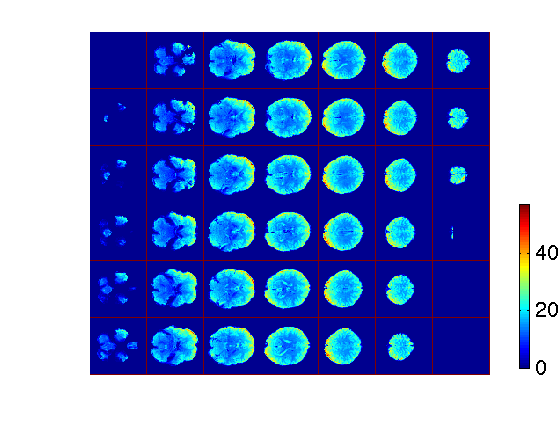

In [3]:
% here the input is the first row of the data matrix, that is, all the voxels from the first TR.
% makeimagestack is a nice function from Kendrick Kay for tiling slices through a 3D volume to a
% 2D plane for visualisation.
imagesc(makeimagestack(data2mat(epivol,epivol.data(1,:))));
% pedantic styling below
axis('off');
set(gca,'dataaspectratio',[epivol.voxsize(1:2) 1])
chandle = colorbar;
set(chandle,'position',get(chandle,'position') .* [1.1 1 .5 .5])

### Import regions of interest to pilab
Suppose you have some ROI masks saved as nifti. Let's import those to pilab.

In [4]:
% add the regions of interest
roivol = roidir2vol(fullfile(resdir,'ROIs'))

roivol = 
  SPMVolume with properties:

              mask: [64x64x40 logical]
            linind: [1x163840 double]
               xyz: [3x163840 double]
            header: [1x1 struct]
           voxsize: [3 3.0000 3.0000]
              data: [2x163840 double]
          nsamples: 2
         nfeatures: 163840
              meta: [1x1 struct]
              desc: [1x1 struct]
    standardstruct: [1x1 struct]
       frameperiod: []


We have two ROIs in rows with voxels in columns as before, but what about the feature dimension? It doesn't seem to match epivol. If we want to make sure the two are in register we can do something like:

In [5]:
[rfepi,rfroi] = intersectvols(epivol,roivol);
rfepi

rfepi = 
  SPMVolume with properties:

              mask: [64x64x40 logical]
            linind: [1x54080 double]
               xyz: [3x54080 double]
            header: [1x1 struct]
           voxsize: [3 3.0000 3.0000]
              data: [777x54080 double]
          nsamples: 777
         nfeatures: 54080
              meta: [1x1 struct]
              desc: [1x1 struct]
    standardstruct: [1x1 struct]
       frameperiod: 2.8000


And now indexing EPI data for a particular ROI is pretty easy:

In [6]:
roiepi = rfepi(:,rfroi.data(1,:)~=0)

roiepi = 
  SPMVolume with properties:

              mask: [64x64x40 logical]
            linind: [1x200 double]
               xyz: [3x200 double]
            header: [1x1 struct]
           voxsize: [3 3.0000 3.0000]
              data: [777x200 double]
          nsamples: 777
         nfeatures: 200
              meta: [1x1 struct]
              desc: [1x1 struct]
    standardstruct: [1x1 struct]
       frameperiod: 2.8000


Notice how the returned volume keeps track of the headers and volumetric registration, so we can still map back to 3D volume at any time. For example, let's verify that the ROI matches what we expect for FFA.

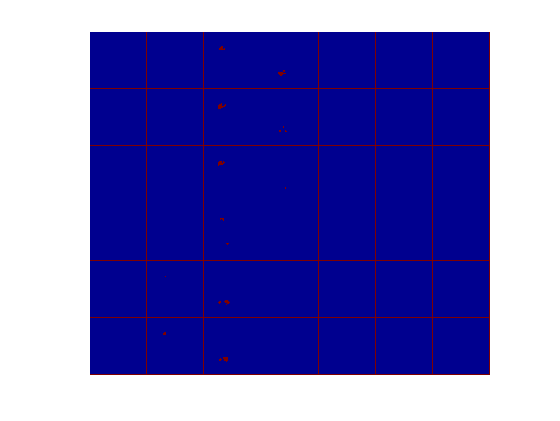

In [7]:
imagesc(makeimagestack(data2mat(roiepi,roiepi.data(1,:)))~=0);
axis('off');
set(gca,'dataaspectratio',[epivol.voxsize(1:2) 1])

### Searchlight mapping
Keeping the 2D data in register with the 3D volume also makes it easy to do searchlight mapping, where a spherical ROI is swept through the brain. The pilab approach to searchlight mapping is to precompute all searchlight ROI masks, which can then be entered into the analysis code like any other roivol.

Below we perform searchlight mapping with a fixed ROI size, which means that the searchlight radius is tuned to achieve a given number of voxels in each ROI. An alternative approach is to simply fix the radius and allow the number of voxels to vary over searchlights.

In [8]:
% heavy lifting ahead - check for matlabpool availability and start a pool if one isn't running already
if ~isempty(which('matlabpool')) && ~matlabpool('size')
    matlabpool local
end
% passing the epivol instance means we run the searchlight mapping on the same voxels as the main dataset.
% You could also enter a nifti instead, e.g. the file we generated above (pilab_mask_updated.nii)
[searchrois,diagnostic] = mask2searchrois(epivol,'nvox',100);

Starting matlabpool using the 'local' profile ... connected to 4 workers.
(mask2searchrois) mapping 54080 searchlights...
(mask2searchrois) finished in 0 days, 00:11:24.110.


Notice the time taken above (about 12 minutes on an i7 processor). The good news is that running the searchlight mapping itself will be considerably faster now that the ROIs have been pre-computed. Radius-based mapping would also be faster.

From this point on, analysis proceeds exactly as with any other pilab ROI analysis. For instance, roidata2rdmvol_lindisc_batch can be called with searchrois to obtain one distance matrix per searchlight (see [part 2]({pilab_demo2_ldc}) of this series), and the result of some comparison between each searchlight and a model RDM can be mapped out to a nifti using the data2file method as above.

### A few searchlight mapping quirks to be aware of
Finally, let's take a look at the `diagnostic` output, which reveals some interesting properties of searchlight mapping.

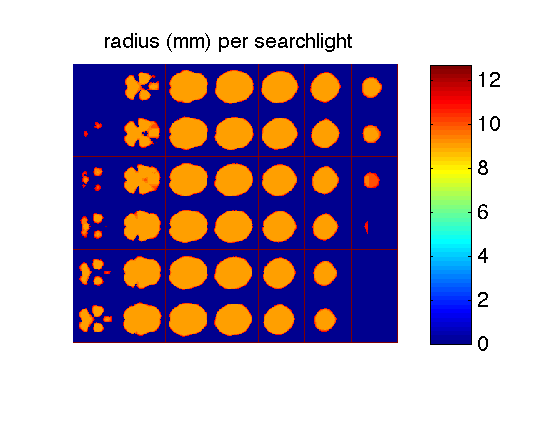

ans =
     9


In [9]:
% visualise the radius of each searchlight
imagesc(makeimagestack(data2mat(epivol,diagnostic.r)));
axis('off');
set(gca,'dataaspectratio',[epivol.voxsize(1:2) 1])
chandle = colorbar;
title('radius (mm) per searchlight')
% typical radius
mode(diagnostic.r)

Although the modal radius is 9mm here, we need bigger spheres close to the edge of the brain since a larger part of each sphere falls outside the brain mask. If we had used a grey-matter mask the pattern would have been more complex (for this and other reasons I no longer recommend volumetric searchlight mapping on grey-matter masked data). 

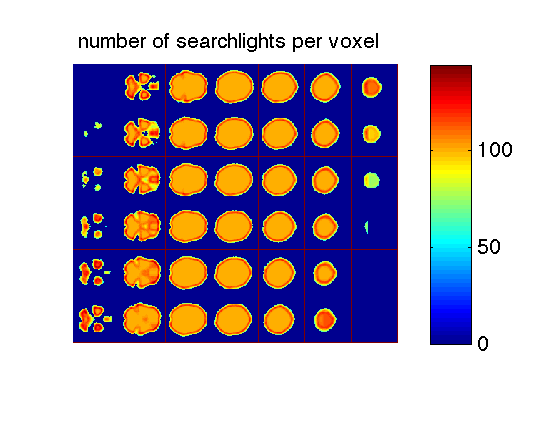

ans =
   100


In [11]:
% visualise how often a each voxel is sampled by a searchlight
imagesc(makeimagestack(data2mat(epivol,diagnostic.nsampled)));
axis('off');
set(gca,'dataaspectratio',[epivol.voxsize(1:2) 1])
chandle = colorbar;
title('number of searchlights per voxel')
% typical number of searchlights per voxel
mode(diagnostic.nsampled)

One consequence of that expanding radius is that voxels close to the border of the brain end up sampled by more searchlight ROIs than voxels on the interior. If larger ROIs tend to show more effect (assuming broadly distributed effects and a method that is tolerant to ROI size), this will tend to produce maps that show more effects on the edge of the brain than in the interior. Conversely, radius-based mapping will tend to favour the interior. So there is bias either way. Don't think this is issue is specific to searchlight mapping though. Similar issues arise with standard univariate fMRI analysis, where Gaussian smoothing will have different effects on the edge of the brain (where you are smoothing in mostly low image-intensity nothing) and on the interior (where you are likely smoothing in high image-intensity white matter noise).

I tend to fix ROI size rather than radius since this makes searchlight results somewhat more comparable to functional ROI analyses (which can be fixed to similar sizes).

That's it for today. Hopefully you have all the tools for a basic single-subject representational similarity analysis at this point. In the next post we will look at how to do inference on those estimates at the single-subject and group level.